# Setup

In [1]:
# import your standard packages
%run ../../global_tools/start.py

# import your local functions
from local_functions import *

# make sure the figures plot inline rather than at the end
%matplotlib inline

Default libraries loaded.


# Paths and Parameters

In [2]:
# these are for grouping into the IOD years since the effects are 
# not confined to a single year. You chose this to have an even 
# number of months around the IOD peak..but now you left it in
# line with the SLA plots that start in 06 and end in 05
IODyear_begin = '-06-01' # month-day of IOD year
IODyear_end = '-05-31' # month-day of year AFTER IOD year

bounds_AS = [68,79,3,20]
bounds_wBoB = [79,87,2,21]
bounds_BoB = [87,100,0,23]

In [3]:
# # change the sla data to get rid of the daily aspect and have month_time = time for future so you can use one function
# # and add it to the external .py file. Also, make the rolling a function of IODyearbegin-1.

# def IOD_year_group_area(invar,begin,end,IODyears):
#     data= []
#     space_data = []
#     for ii,year in enumerate(IODyears):
#         start_time = str(year) + begin
#         end_time = str(year+1) + end
#         time_slice = slice(start_time, end_time)
#         sp_data = invar.sel(time=time_slice)
#         area_avg = sp_data.stack(allpoints = ['lat','lon']).mean(dim='allpoints')
#         data.append(area_avg)
#         space_data.append(sp_data)
        
#     # add all the data together
#     data_concat = xr.concat(data, dim='time')
#     # average
#     # take the mean for each month of all the years
#     data_mean = data_concat.groupby('time.month').mean(dim='time')
#     #start in June instead of 01
#     data_mean = data_mean.roll(month=-5,roll_coords = False)
        
#     return data, data_mean, space_data

# Get Data

In [4]:
ds_CHL = xr.open_dataset('../data/chl_processed.nc')
ds_CHL

<xarray.Dataset>
Dimensions:           (lat: 828, lon: 1296, month: 12, time: 273)
Coordinates:
  * lon               (lon) float64 48.52 48.56 48.6 48.65 ... 102.4 102.4 102.5
  * lat               (lat) float64 -1.479 -1.438 -1.396 ... 32.9 32.94 32.98
  * time              (time) datetime64[ns] 1997-09-04 1997-10-01 ... 2020-05-01
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mon_chl           (time, lat, lon) float64 ...
    mon_chl_mon_clim  (month, lat, lon) float64 ...
    mon_chl_mon_anom  (time, lat, lon) float64 ...

# Subset

In [5]:
#----------------- Arabian Sea ---------------------#

# Get data, selecting lat/lon slice
lat_slice_AS = slice(bounds_AS[2],bounds_AS[3]) 
lon_slice_AS = slice(bounds_AS[0],bounds_AS[1])

# subset gridded data 
mon_chl_AS = ds_CHL['mon_chl'].sel(lat=lat_slice_AS,lon=lon_slice_AS)
mon_chl_mon_anom_AS = ds_CHL['mon_chl_mon_anom'].sel(lat=lat_slice_AS,lon=lon_slice_AS)
mon_chl_mon_clim_AS = ds_CHL['mon_chl_mon_clim'].sel(lat=lat_slice_AS,lon=lon_slice_AS)
lat_AS = mon_chl_mon_anom_AS.lat.values
lon_AS = mon_chl_mon_anom_AS.lon.values
time_AS = mon_chl_mon_anom_AS.time.values


#---------------- Western Bay of Bengal --------------------#

lat_slice_wBoB = slice(bounds_wBoB[2],bounds_wBoB[3])
lon_slice_wBoB = slice(bounds_wBoB[0],bounds_wBoB[1])

# subset gridded data 
mon_chl_wBoB = ds_CHL['mon_chl'].sel(lat=lat_slice_wBoB,lon=lon_slice_wBoB)
mon_chl_mon_anom_wBoB = ds_CHL['mon_chl_mon_anom'].sel(lat=lat_slice_wBoB,lon=lon_slice_wBoB)
mon_chl_mon_clim_wBoB = ds_CHL['mon_chl_mon_clim'].sel(lat=lat_slice_wBoB,lon=lon_slice_wBoB)
lat_wBoB = mon_chl_mon_anom_wBoB.lat.values
lon_wBoB = mon_chl_mon_anom_wBoB.lon.values
time_wBoB = mon_chl_mon_anom_wBoB.time.values

#---------------- Bay of Bengal --------------------#
lat_slice_BoB = slice(bounds_BoB[2],bounds_BoB[3])
lon_slice_BoB = slice(bounds_BoB[0],bounds_BoB[1])

# subset gridded data 
mon_chl_BoB = ds_CHL['mon_chl'].sel(lat=lat_slice_BoB,lon=lon_slice_BoB)
mon_chl_mon_anom_BoB = ds_CHL['mon_chl_mon_anom'].sel(lat=lat_slice_BoB,lon=lon_slice_BoB)
mon_chl_mon_clim_BoB = ds_CHL['mon_chl_mon_clim'].sel(lat=lat_slice_BoB,lon=lon_slice_BoB)
lat_BoB = mon_chl_mon_anom_BoB.lat.values
lon_BoB = mon_chl_mon_anom_BoB.lon.values
time_BoB = mon_chl_mon_anom_BoB.time.values

## <font color='orange'>Group Into IOD Phases</font> 

In [7]:
# load DMI data
ds_DMI= xr.open_dataset('../data/dmi_processed.nc')
ds_DMI

posIODyears = list(np.array(ds_DMI.pos_IOD_years[(ds_DMI.pos_IOD_years >= 1997) & (ds_DMI.pos_IOD_years <=2019)]))
negIODyears = list(np.array(ds_DMI.neg_IOD_years[(ds_DMI.neg_IOD_years >= 1997) & (ds_DMI.neg_IOD_years <=2019)]))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years[(ds_DMI.neu_IOD_years >= 1997) & (ds_DMI.neu_IOD_years <=2019)]))
allyears = list(np.arange(1997,2020)) # ends on 2019

# identify boxes

In [8]:
def IOD_year_group_area(invar,begin,end,IODyears,cbounds=[48.5, 102.5,-1.5, 33],coast = True):
    import numpy as np
    import xarray as xr
    
    data= []
    space_data = []
    for ii,year in enumerate(IODyears):
        start_time = str(year) + begin
        end_time = str(year+1) + end
        time_slice = slice(start_time, end_time)
        sp_data = invar.sel(time=time_slice)
        if coast == True:
            xx,yy = np.meshgrid(sp_data.lon,sp_data.lat)
            mask = mask_coast(xx.flatten(),yy.flatten(),cbounds)
            sp_data_c = sp_data.stack(allpoints=['lat','lon'])[:,mask]
            area_avg = np.mean(sp_data_c,1)
            
        else:
            area_avg = sp_data.stack(allpoints = ['lat','lon']).mean(dim='allpoints')
           
        data.append(area_avg)
        space_data.append(sp_data)
        
    # add all the data together
    data_concat = xr.concat(data, dim='time')
    # average
    # take the mean for each month of all the years
    data_mean = data_concat.groupby('time.month').mean(dim='time')
    #start in June instead of 01
    data_mean = data_mean.roll(month=-5,roll_coords = False)
        
    print('...')
    return data, data_mean, space_data

In [18]:
var = mon_chl_AS
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIOD_mon_chl_AS,posIOD_mon_chl_mean_AS,posIOD_mon_chl_sp_AS = IOD_year_group_area(var,IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIOD_mon_chl_AS,negIOD_mon_chl_mean_AS,negIOD_mon_chl_sp_AS = IOD_year_group_area(var,IODyear_begin,IODyear_end,negIODyears)


# average over the positive IOD years -------------------------------------------# 
neuIOD_mon_chl_AS,neuIOD_mon_chl_mean_AS,neuIOD_mon_chl_sp_AS = IOD_year_group_area(var,IODyear_begin,IODyear_end,neuIODyears)


# average over all years -------------------------------------------# 
mon_clim_mon_chl_AS,mon_clim_mon_chl_mean_AS,mon_clim_mon_chl_sp_AS = IOD_year_group_area(var,IODyear_begin,IODyear_end,allyears)




var = mon_chl_wBoB
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIOD_mon_chl_wBoB,posIOD_mon_chl_mean_wBoB,posIOD_mon_chl_sp_wBoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,posIODyears)


# average over the positive IOD years -------------------------------------------# 
negIOD_mon_chl_wBoB,negIOD_mon_chl_mean_wBoB,negIOD_mon_chl_sp_wBoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,negIODyears)

# average over the positive IOD years -------------------------------------------# 
neuIOD_mon_chl_wBoB,neuIOD_mon_chl_mean_wBoB,neuIOD_mon_chl_sp_wBoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,neuIODyears)

# average over all years -------------------------------------------# 
mon_clim_mon_chl_wBoB,mon_clim_mon_chl_mean_wBoB,mon_clim_mon_chl_sp_wBoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,allyears)

var = mon_chl_BoB
# ------------------------------------------------------------#
# Bin
# ------------------------------------------------------------#
    
# average over the positive IOD years -------------------------------------------# 
posIOD_mon_chl_BoB,posIOD_mon_chl_mean_BoB,posIOD_mon_chl_sp_BoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,posIODyears)

# average over the positive IOD years -------------------------------------------# 
negIOD_mon_chl_BoB,negIOD_mon_chl_mean_BoB,negIOD_mon_chl_sp_BoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,negIODyears)

# average over the positive IOD years -------------------------------------------# 
neuIOD_mon_chl_BoB,neuIOD_mon_chl_mean_BoB,neuIOD_mon_chl_sp_BoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,neuIODyears)

# average over all years -------------------------------------------# 
mon_clim_mon_chl_BoB,mon_clim_mon_chl_mean_BoB,mon_clim_mon_chl_sp_BoB = IOD_year_group_area(var,IODyear_begin,IODyear_end,allyears)



...
...
...
...
...
...
...
...
...
...
...
...


In [139]:
# flatten
posIODdata_AS = xr.concat(posIOD_mon_chl_sp_AS, dim='time')
nm = posIODdata_AS.shape[1]*posIODdata_AS.shape[2]

posIODmon_AS = []
for tt in range(len(posIODdata_AS.time)):
    t = np.array(posIODdata_AS.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        posIODmon_AS.extend(t)
                        
posIODmon_AS = np.array(posIODmon_AS)
posIODdata_AS = np.array(posIODdata_AS).flatten()

negIODdata_AS = xr.concat(negIOD_mon_chl_sp_AS, dim='time')
nm = negIODdata_AS.shape[1]*negIODdata_AS.shape[2]

negIODmon_AS = []
for tt in range(len(negIODdata_AS.time)):
    t = np.array(negIODdata_AS.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        negIODmon_AS.extend(t)
                        
negIODmon_AS = np.array(negIODmon_AS)
negIODdata_AS = np.array(negIODdata_AS).flatten()

# ---------------------------------------------
posIODdata_wBoB = xr.concat(posIOD_mon_chl_sp_wBoB, dim='time')
nm = posIODdata_wBoB.shape[1]*posIODdata_wBoB.shape[2]

posIODmon_wBoB = []
for tt in range(len(posIODdata_wBoB.time)):
    t = np.array(posIODdata_wBoB.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        posIODmon_wBoB.extend(t)
                        
posIODmon_wBoB = np.array(posIODmon_wBoB)
posIODdata_wBoB = np.array(posIODdata_wBoB).flatten()

negIODdata_wBoB = xr.concat(negIOD_mon_chl_sp_wBoB, dim='time')
nm = negIODdata_wBoB.shape[1]*negIODdata_wBoB.shape[2]

negIODmon_wBoB = []
for tt in range(len(negIODdata_wBoB.time)):
    t = np.array(negIODdata_wBoB.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        negIODmon_wBoB.extend(t)
                        
negIODmon_wBoB = np.array(negIODmon_wBoB)
negIODdata_wBoB = np.array(negIODdata_wBoB).flatten()


# ---------------------------------------------
posIODdata_BoB = xr.concat(posIOD_mon_chl_sp_BoB, dim='time')
nm = posIODdata_BoB.shape[1]*posIODdata_BoB.shape[2]

posIODmon_BoB = []
for tt in range(len(posIODdata_BoB.time)):
    t = np.array(posIODdata_BoB.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        posIODmon_BoB.extend(t)
                        
posIODmon_BoB = np.array(posIODmon_BoB)
posIODdata_BoB = np.array(posIODdata_BoB).flatten()

negIODdata_BoB = xr.concat(negIOD_mon_chl_sp_BoB, dim='time')
nm = negIODdata_BoB.shape[1]*negIODdata_BoB.shape[2]

negIODmon_BoB = []
for tt in range(len(negIODdata_BoB.time)):
    t = np.array(negIODdata_BoB.time.dt.month[tt:tt+1]) 
    for sp in range(nm):
        negIODmon_BoB.extend(t)
                        
negIODmon_BoB = np.array(negIODmon_BoB)
negIODdata_BoB = np.array(negIODdata_BoB).flatten()



0  # data for positive IOD years:  4995349
0  # data for negative IOD years:  2512965
1  # data for positive IOD years:  4324347
1  # data for negative IOD years:  2189807
2  # data for positive IOD years:  8067540
2  # data for negative IOD years:  4010162


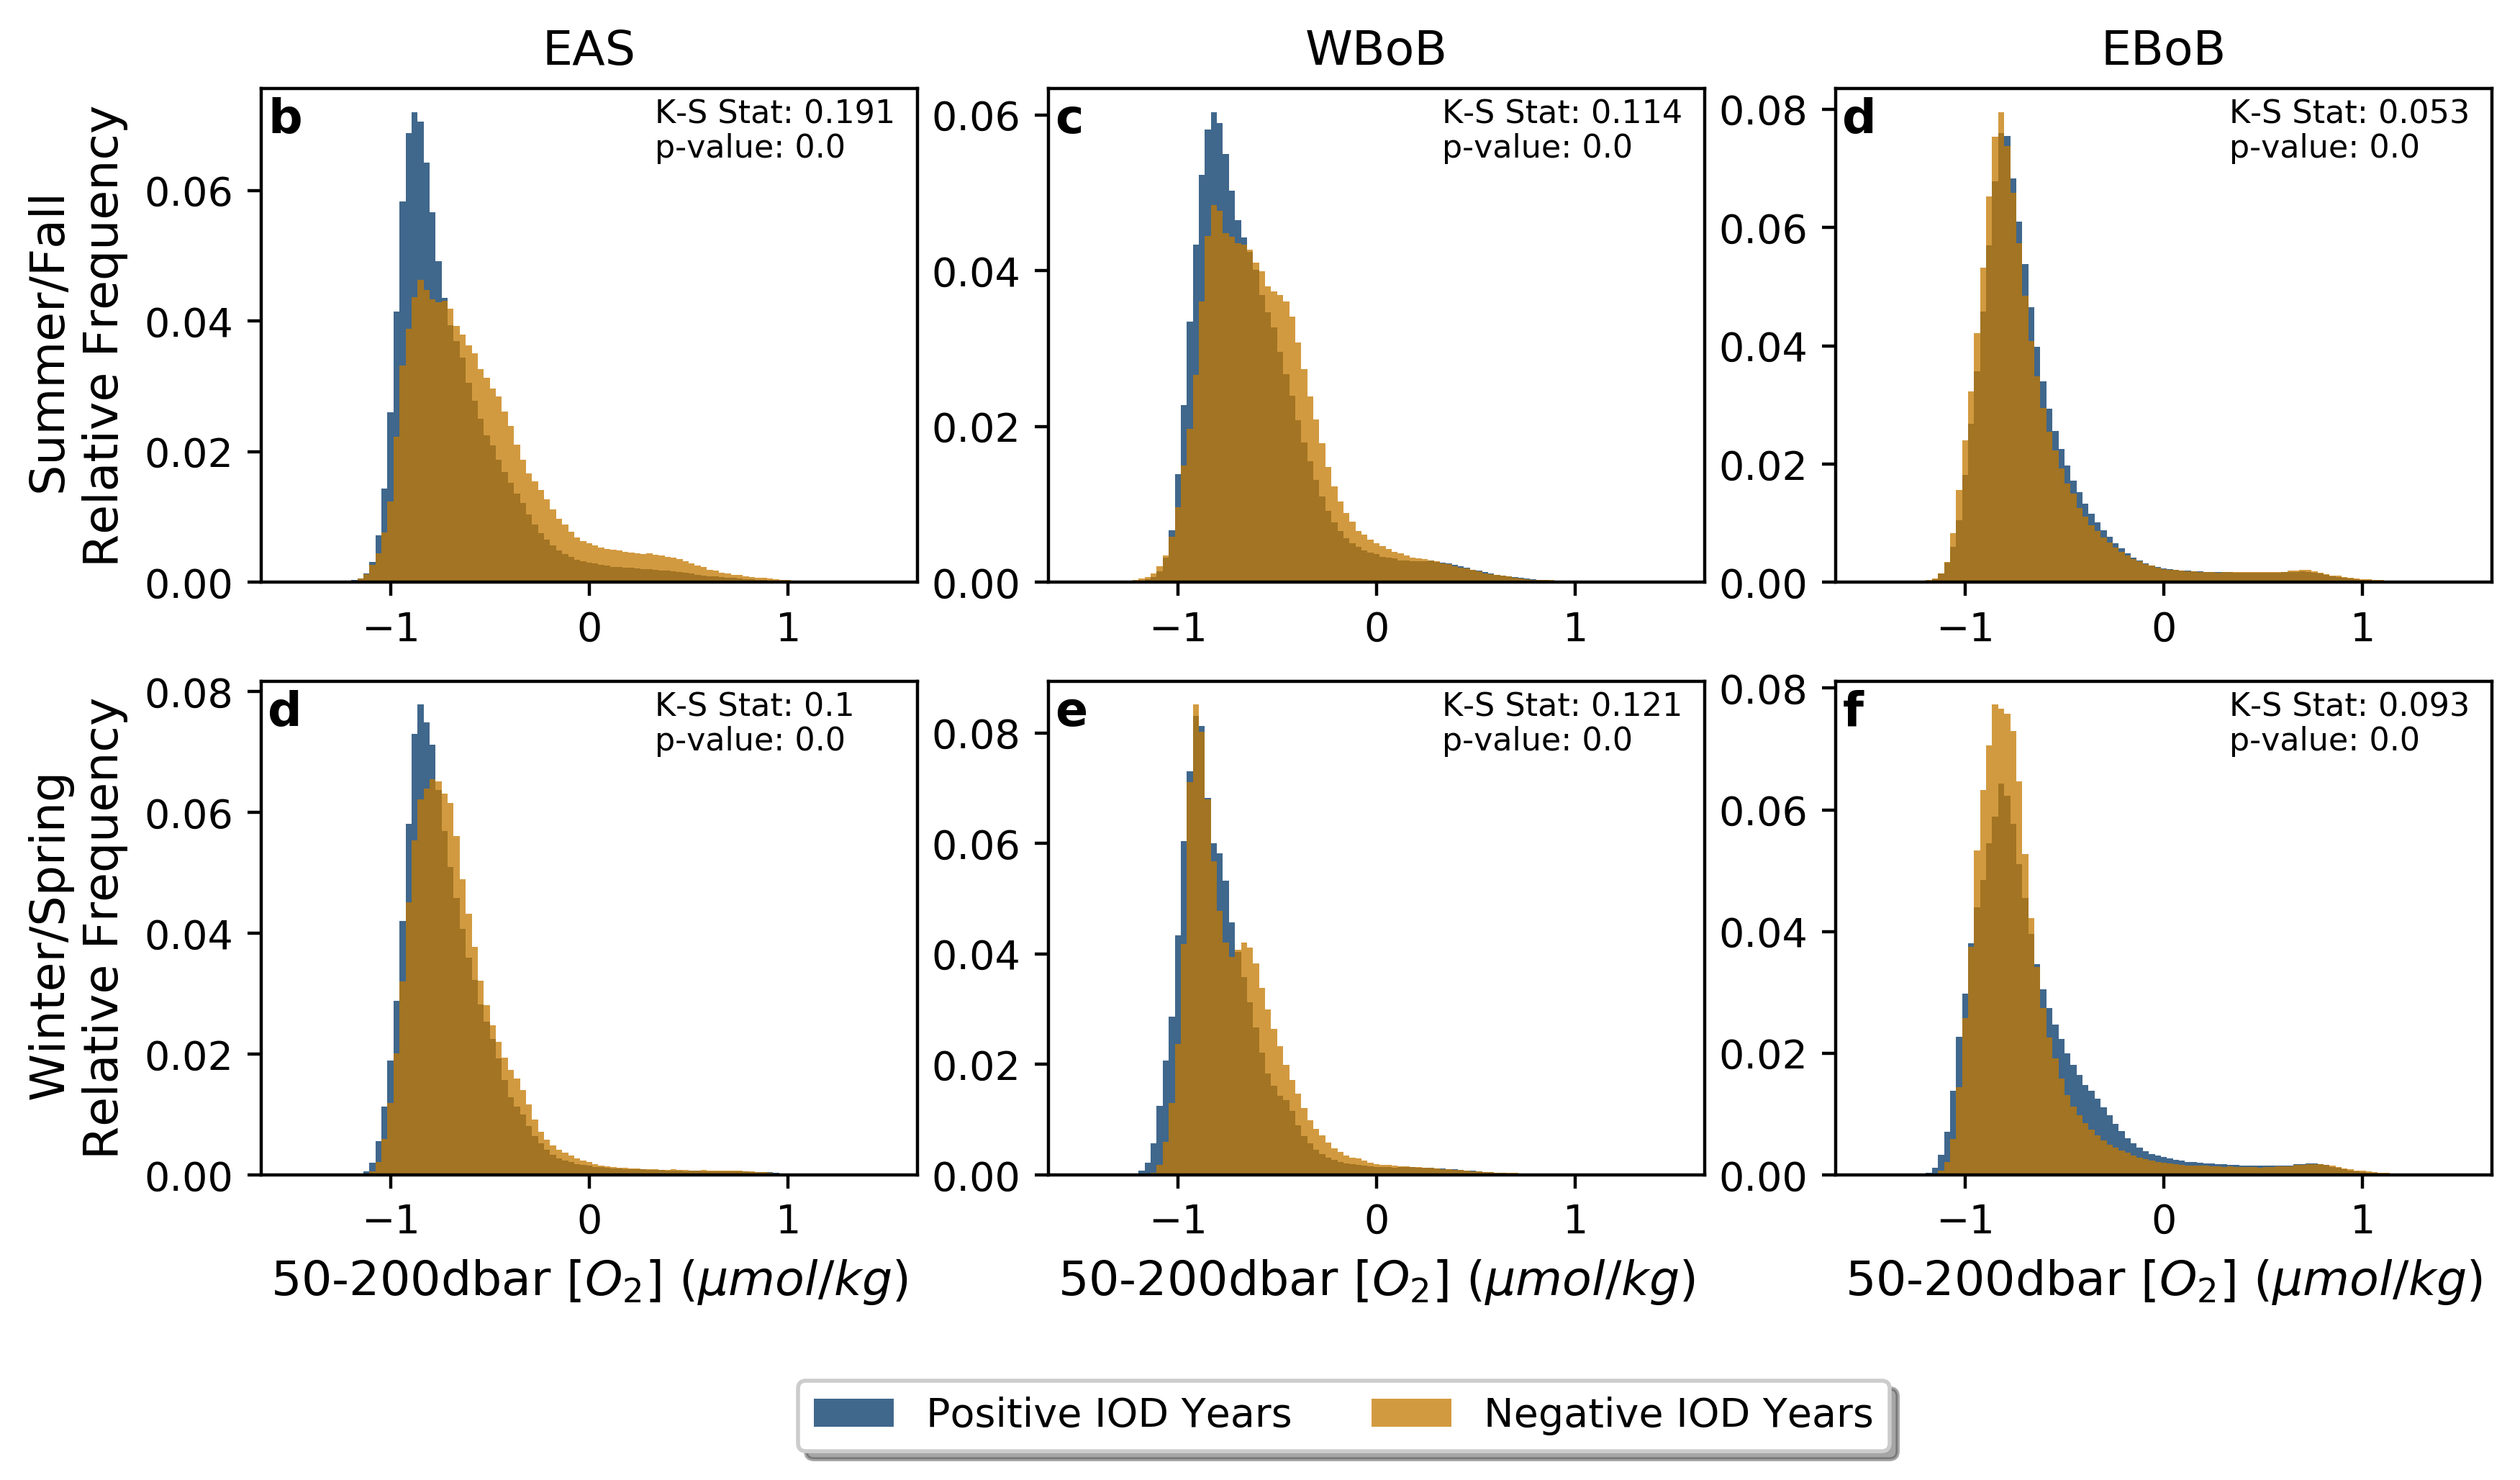

In [156]:
# Make Histograms 
binedges = np.linspace(-1.5,1.5,100)
names = ['Positive IOD Years','Negative IOD Years','All Observed Years']
# title = ['Eastern Arabian Sea', 'Western Bay of Bengal','Eastern Bay of Bengal']
title = ['EAS', 'WBoB','EBoB']
# colors = ['teal','orange','purple']
colors = ['#003466','#C47900']
letters = ['a','b','c','d','e','f']

fig = plt.figure(figsize=(10, 5), dpi=400)

params = {'legend.fontsize': 10,
         'axes.labelsize': 12,
         'axes.titlesize': 12,
         'xtick.labelsize':10,
         'ytick.labelsize':10}

pylab.rcParams.update(params)

#########################

data_AS = [posIODdata_AS,negIODdata_AS]
data_wBoB = [posIODdata_wBoB,negIODdata_wBoB]
data_BoB = [posIODdata_BoB,negIODdata_BoB]
time_data_AS = [posIODmon_AS,negIODmon_AS]
time_data_wBoB = [posIODmon_wBoB,negIODmon_wBoB]
time_data_BoB = [posIODmon_BoB,negIODmon_BoB]

cnt = 1
for pp in range(3):

    if pp==0:
        pdata = np.log10(data_AS[0])
        ndata = np.log10(data_AS[1])
#         alldata = data_AS[2]
        
        ptdata = time_data_AS[0]
        ntdata = time_data_AS[1]
#         alltdata = time_data_AS[2]
        
    elif pp==1:
        pdata = np.log10(data_wBoB[0])
        ndata = np.log10(data_wBoB[1])
#         alldata = data_wBoB[2]
        
        ptdata = time_data_wBoB[0]
        ntdata = time_data_wBoB[1]
#         alltdata = time_data_wBoB[2]
        
    else:
        pdata = np.log10(data_BoB[0])
        ndata = np.log10(data_BoB[1])
#         alldata = data_BoB[2]
        
        ptdata = time_data_BoB[0]
        ntdata = time_data_BoB[1]
#         alltdata = time_data_BoB[2]

    # O2
    x1 = pdata[~np.isnan(pdata)]
    x2 = ndata[~np.isnan(ndata)]
#     x3 = alldata[~np.isnan(alldata)]

    x1t = ptdata[~np.isnan(pdata)]
    x2t = ntdata[~np.isnan(ndata)]
#     x3t = alltdata[~np.isnan(alldata)]
    
    print(pp, ' # data for positive IOD years: ',len(x1))
    print(pp, ' # data for negative IOD years: ',len(x2))
#     print(pp, ' # data for all years: ',len(x3))

    # get seasonal indicies
    ind_sf = (x1t == 6) | (x1t == 7) | (x1t == 8) | (x1t == 9) | (x1t == 10) | (x1t == 11)
    ind_ws = (x1t == 12) | (x1t == 1) | (x1t == 2) | (x1t == 3) | (x1t == 4) | (x1t ==5)

    x1_sf = x1[ind_sf]
    x1_ws = x1[ind_ws]

    ind_sf = (x2t == 6) | (x2t == 7) | (x2t == 8) | (x2t == 9) | (x2t == 10) | (x2t == 11)
    ind_ws = (x2t == 12) | (x2t == 1) | (x2t == 2) | (x2t == 3) | (x2t == 4) | (x2t ==5)

    x2_sf = x2[ind_sf]
    x2_ws = x2[ind_ws]

#     ind_sf = (x3t == 6) | (x3t == 7) | (x3t == 8) | (x3t == 9) | (x3t == 10) | (x3t == 11)
#     ind_ws = (x3t == 12) | (x3t == 1) | (x3t == 2) | (x3t == 3) | (x3t == 4) | (x3t ==5)

#     x3_sf = x3[ind_sf]
#     x3_ws = x3[ind_ws]
    

    # ks test

    pos_neg_ks_sf = stats.ks_2samp(x1_sf,x2_sf)
#     pos_all_ks_sf = stats.ks_2samp(x1_sf,x3_sf)
#     neg_all_ks_sf = stats.ks_2samp(x2_sf,x3_sf)

    pos_neg_ks_ws = stats.ks_2samp(x1_ws,x2_ws)
#     pos_all_ks_ws = stats.ks_2samp(x1_ws,x3_ws)
#     neg_all_ks_ws = stats.ks_2samp(x2_ws,x3_ws)

    # weights for relative frequency
    
    weights_sf = [np.zeros_like(x1_sf) + 1./len(x1_sf),
              np.zeros_like(x2_sf) + 1./len(x2_sf)]
#               np.zeros_like(x3_sf) + 1./len(x3_sf)]

    weights_ws = [np.zeros_like(x1_ws) + 1./len(x1_ws),
              np.zeros_like(x2_ws) + 1./len(x2_ws)]
#               np.zeros_like(x3_ws) + 1./len(x3_ws)]

    #subplot summer fall
    ax = fig.add_subplot(2,3,cnt)
    plt.hist(x1_sf,bins = binedges, weights=weights_sf[0],
                 alpha=0.75,color = colors[0], label=names[0])
    plt.hist(x2_sf,bins = binedges, weights=weights_sf[1],
                 alpha=0.75,color = colors[1], label=names[1])
#     ax.set_ylim([0,0.45])
    ax.set_title(title[pp])
    
    if cnt == 1:
        ax.set_ylabel('Summer/Fall \nRelative Frequency')
#     if cnt == 3:
#         ax2 = ax.twinx()
#         ax2.set_yticks([])
#         ax2.set_yticklabels([])
#         ax2.set_ylabel('Summer/Fall')
        
    add_letter(ax, letters[cnt], x = 0.01,y=0.91)
    add_text(ax, 'K-S Stat: ' + str(np.round(pos_neg_ks_sf[0],3)), x = 0.6,y=0.93, fontsize = 8)
    add_text(ax, 'p-value: ' + str(np.round(pos_neg_ks_sf[1],4)), x = 0.6,y=0.86, fontsize = 8)
    
    # subplot winter spring
    ax = fig.add_subplot(2,3,cnt + 3)
    plt.hist(x1_ws,bins = binedges, weights=weights_ws[0],
                 alpha=0.75,color = colors[0], label=names[0])
    plt.hist(x2_ws,bins = binedges, weights=weights_ws[1],
                 alpha=0.75,color = colors[1], label=names[1])
#     ax.set_ylim([0,0.75])
    ax.set_xlabel('50-200dbar [$O_2$] ($\mu mol/ kg$)')
#     ax.set_xscale('log')
    if cnt == 1:
        ax.set_ylabel('Winter/Spring \nRelative Frequency')
#     if cnt == 3:
#         ax2 = ax.twinx()
#         ax2.set_yticks([])
#         ax2.set_yticklabels([])
#         ax2.set_ylabel('Winter/Spring')
        
    add_letter(ax, letters[cnt+2], x = 0.01,y=0.91)
    add_text(ax, 'K-S Stat: ' + str(np.round(pos_neg_ks_ws[0],3)), x = 0.6,y=0.93, fontsize = 8)
    add_text(ax, 'p-value: ' + str(np.round(pos_neg_ks_ws[1],4)), x = 0.6,y=0.86, fontsize = 8)
    
    cnt += 1

ax.legend(loc='lower center', bbox_to_anchor=(-.75, -.6),
          ncol=2, fancybox=True, shadow=True)

In [132]:
len(x1_sf)

0

In [33]:
pdata.shape

(7432128,)